In [24]:
import os
import pandas as pd
import numpy as np
import json
import joblib
import pickle
import requests
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns', 500)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


### Reading Data

In [40]:
df = pd.read_csv(r'/Users/joaopinto/projects/Capstone-LDSA/data/two-years-recid.csv')
df.head()

,id,name,sex,dob,age,race,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,juv_fel_count,juv_misd_count,juv_other_count,priors_count,compas_screening_date,type_of_assessment,decile_score,score_text,v_type_of_assessment,v_decile_score,v_score_text,is_recid,r_case_number,r_offense_date,r_charge_degree,r_charge_desc,is_violent_recid,vr_case_number,vr_offense_date,vr_charge_degree,vr_charge_desc,two_year_recid
0,1,steven lux,Male,1953-06-15,62,Caucasian,2013-01-05 04:35:31,2013-01-07 03:18:03,13000208CF10A,2013-01-05,NaN,F,False Imprisonment,0,0,0,0,2013-01-05,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
1,2,andre small,Male,1987-10-01,28,African-American,2013-04-02 12:18:46,2013-04-04 07:54:22,13006354MM10A,2013-04-02,NaN,M,Battery,0,0,0,1,2013-04-03,Risk of Recidivism,3,Low,Risk of Violence,3,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,3,willie gray,Male,1959-01-12,57,African-American,2014-10-31 12:02:01,2014-10-31 01:47:05,14040148MU10A,2014-10-30,NaN,M,DUI Level 0.15 Or Minor In Veh,0,0,0,8,2014-10-31,Risk of Recidivism,4,Low,Risk of Violence,2,Low,1,15043364TC20A,2015-07-23,(M2),Driving License Suspended,0,NaN,NaN,NaN,NaN,1
3,4,nickson marcellus,Male,1996-07-11,19,African-American,2014-01-23 03:19:30,2014-01-23 01:04:34,13017969CF10A,NaN,2014-01-23,F,arrest case no charge,0,1,0,1,2014-01-23,Risk of Recidivism,10,High,Risk of Violence,10,High,1,16000241MM20A,2016-01-04,(M1),Possess Cannabis/20 Grams Or Less,0,NaN,NaN,NaN,NaN,1
4,5,patria barnes,Female,1978-06-06,37,Other,2013-12-08 01:55:28,2013-12-09 02:00:59,13022717MM10A,2013-12-07,NaN,M,Battery,0,0,0,0,2013-12-09,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


### Feature Engineering

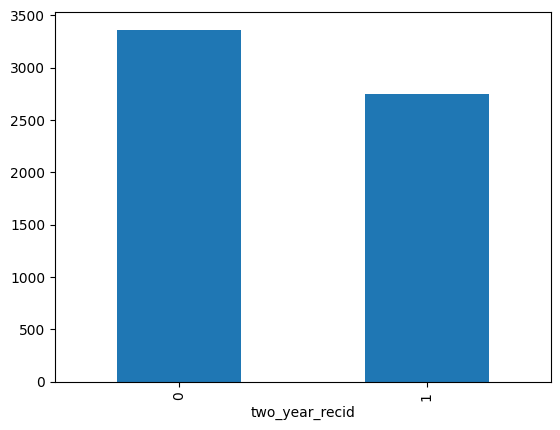

In [41]:
target = 'two_year_recid'
y = df[target]
y.value_counts().plot(kind='bar');

In [42]:
X = df[[col for col in df.columns if col != target]]

drop_cols = [
    'id',
    'name',
    'dob',
    'race',
    'score_text',
    #'c_jail_in',
    #'c_jail_out',
    'c_case_number',
    'compas_screening_date',
    'c_offense_date',
    'c_arrest_date',
    'r_case_number',
    'r_offense_date',
    'vr_case_number',
    'vr_offense_date'
    
]

X = X.drop(columns=drop_cols)
X.head()


,sex,age,c_jail_in,c_jail_out,c_charge_degree,c_charge_desc,juv_fel_count,juv_misd_count,juv_other_count,priors_count,type_of_assessment,decile_score,v_type_of_assessment,v_decile_score,v_score_text,is_recid,r_charge_degree,r_charge_desc,is_violent_recid,vr_charge_degree,vr_charge_desc
0,Male,62,2013-01-05 04:35:31,2013-01-07 03:18:03,F,False Imprisonment,0,0,0,0,Risk of Recidivism,1,Risk of Violence,1,Low,0,NaN,NaN,0,NaN,NaN
1,Male,28,2013-04-02 12:18:46,2013-04-04 07:54:22,M,Battery,0,0,0,1,Risk of Recidivism,3,Risk of Violence,3,Low,0,NaN,NaN,0,NaN,NaN
2,Male,57,2014-10-31 12:02:01,2014-10-31 01:47:05,M,DUI Level 0.15 Or Minor In Veh,0,0,0,8,Risk of Recidivism,4,Risk of Violence,2,Low,1,(M2),Driving License Suspended,0,NaN,NaN
3,Male,19,2014-01-23 03:19:30,2014-01-23 01:04:34,F,arrest case no charge,0,1,0,1,Risk of Recidivism,10,Risk of Violence,10,High,1,(M1),Possess Cannabis/20 Grams Or Less,0,NaN,NaN
4,Female,37,2013-12-08 01:55:28,2013-12-09 02:00:59,M,Battery,0,0,0,0,Risk of Recidivism,1,Risk of Violence,1,Low,0,NaN,NaN,0,NaN,NaN


### Pipeline

In [9]:
# Define preprocessing steps
numeric_features = ['age']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [col for col in X.columns if col not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(C=0.1,penalty='l2', random_state=42,))

In [21]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.9697465249386754
Confusion Matrix:
[[625  37]
 [  0 561]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       662
           1       0.94      1.00      0.97       561

    accuracy                           0.97      1223
   macro avg       0.97      0.97      0.97      1223
weighted avg       0.97      0.97      0.97      1223



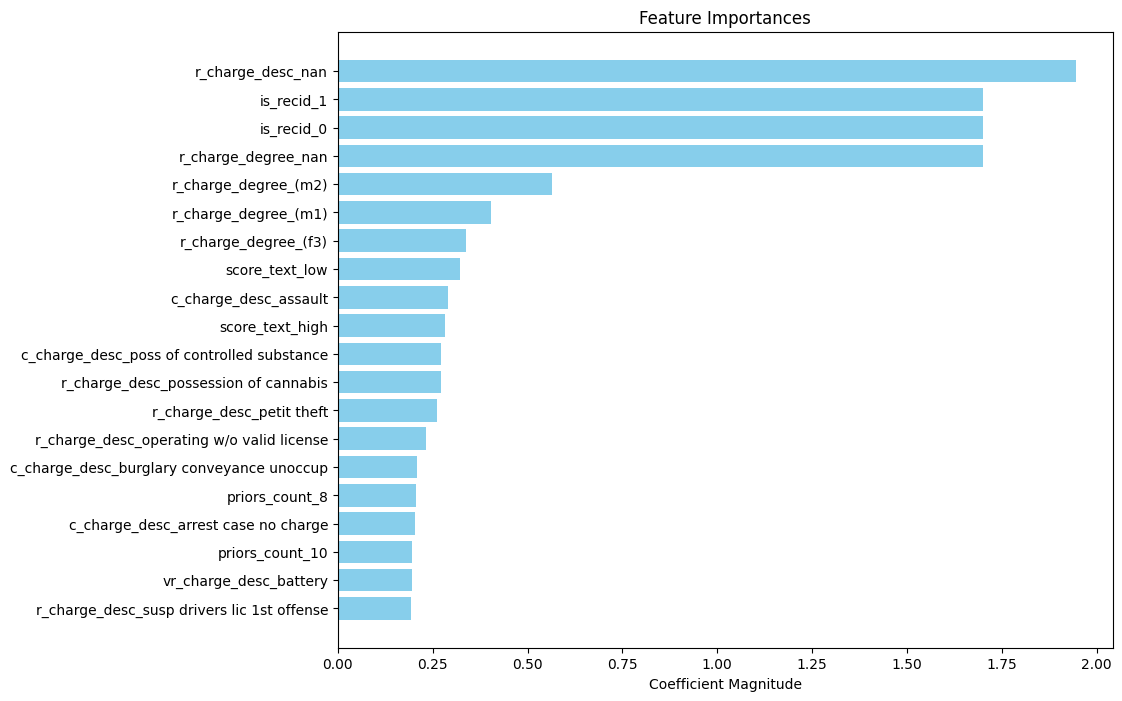

In [26]:
# Extract feature names after one-hot encoding
numeric_features = np.array(numeric_features)
categorical_transformer = pipeline.named_steps['columntransformer'].named_transformers_['cat']
categorical_feature_names = categorical_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, categorical_feature_names])

# Get the coefficients from the logistic regression model
log_reg = pipeline.named_steps['logisticregression']
coefficients = log_reg.coef_[0]

# Create a dataframe for feature names and their corresponding coefficients
import pandas as pd
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the dataframe by the absolute value of the coefficients
feature_importances['Importance'] = np.abs(feature_importances['Coefficient'])
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).head(20)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

<Axes: xlabel='r_charge_desc'>

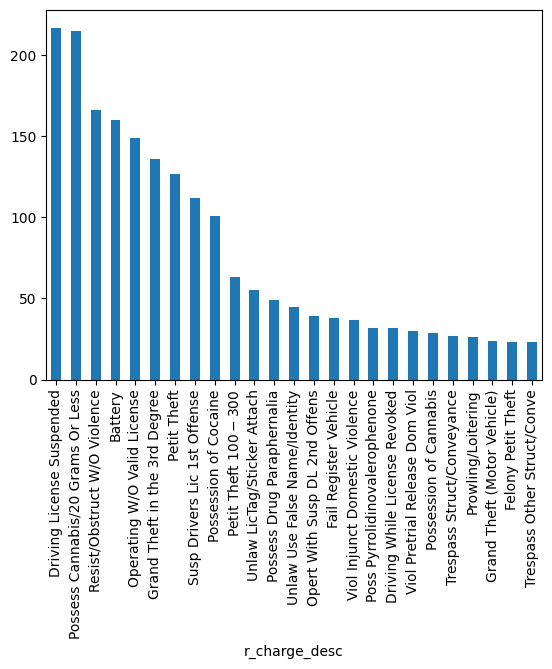

In [45]:
df['r_charge_desc'].value_counts().head(25).plot(kind='bar')

### Model Choice

In [11]:

# Define a dictionary of models with their respective parameter grids for hyperparameter tuning
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__penalty': ['l1', 'l2']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'classifier__max_depth': [None, 5, 10, 20],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    #'Random Forest': {
    #    'model': RandomForestClassifier(),
    #    'params': {
    #        'classifier__n_estimators': [100, 200, 300],
    #        'classifier__max_depth': [None, 5, 10, 20],
    #        'classifier__min_samples_split': [2, 5, 10],
    #        'classifier__min_samples_leaf': [1, 2, 4],
    #        'classifier__bootstrap': [True, False]
    #    }
    #},
    #'Support Vector Machine': {
    #    'model': SVC(),
    #    'params': {
    #        'classifier__C': [0.1, 1.0, 10.0],
    #        'classifier__kernel': ['linear', 'rbf']
    #    }
    #},
    #'AdaBoost': {
    #    'model': AdaBoostClassifier(),
    #    'params': {
    #        'classifier__n_estimators': [50, 100, 200],
    #        'classifier__learning_rate': [0.01, 0.1, 1.0]
    #    }
    #},
    #'Gradient Boosting': {
    #    'model': GradientBoostingClassifier(),
    #    'params': {
    #        'classifier__n_estimators': [50, 100, 200],
    #        'classifier__learning_rate': [0.01, 0.1, 1.0],
    #        'classifier__max_depth': [3, 5, 7]
    #    }
    #},
    #'K-Nearest Neighbors': {
    #    'model': KNeighborsClassifier(),
    #    'params': {
    #        'classifier__n_neighbors': [3, 5, 7],
    #        'classifier__weights': ['uniform', 'distance']
    #    }
    #},
    #'Multi-layer Perceptron': {
    #    'model': MLPClassifier(),
    #    'params': {
    #        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
    #        'classifier__activation': ['logistic', 'relu'],
    #        'classifier__alpha': [0.0001, 0.001, 0.01]
    #    }
    #}
}

# Test each model using grid search for hyperparameter tuning
for name, model_info in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model_info['model'])])
    
    grid_search = GridSearchCV(pipeline, model_info['params'], cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"F1 Score: {round(grid_search.best_score_,2)}")


Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
F1 Score: 0.97
Best parameters for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
F1 Score: 0.97
